In [10]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
from itertools import permutations
from operator import itemgetter
from time import time
from math import factorial

from google.colab import drive
drive.mount('/gdrive')
import glob
os.chdir(glob.glob("/gdrive/My Drive/Colab Notebooks/OR/")[0])

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


# Q1

In [0]:
def readData():
    network = {}
    node2node = {}
    nodes = []
    file = open("petroleum field.txt")
    for line in file.readlines():
        value = line.strip().split()
        nFrom = value[0]
        nTo = value[1]
        network[(nFrom, nTo)] = list(map(lambda x: float(x), value[2:])) + [0]
        if nFrom not in node2node.keys():
            node2node[nFrom] = [nTo]
        else:
            node2node[nFrom] = node2node[nFrom] + [nTo]
        if nFrom not in nodes:
            nodes.append(nFrom)
        if nTo not in nodes:
            nodes.append(nTo)
    file.close()
    return nodes, node2node, network

def BFS(node2node, network):
    '''
    Find augmented path in BFS
    '''
    queue = ["s"]
    father = {}
    while(len(queue)):
        nFrom = queue[0]
        queue = queue[1:]
        for nTo in node2node[nFrom]:
            _, capacity, flow = network[(nFrom, nTo)]
            if capacity > flow and nTo not in queue:
                queue.append(nTo)
                father[nTo] = nFrom
                if nTo == "t":
                    augmentedPath = []
                    curNode = "t"
                    deltaFlow = np.inf
                    while(curNode != "s"):
                        augmentedPath.insert(0, curNode)
                        _, capacity, flow = network[(father[curNode], curNode)]
                        augmentedFlow = capacity - flow
                        if deltaFlow > augmentedFlow:
                            deltaFlow = augmentedFlow
                        curNode = father[curNode]
                    augmentedPath.insert(0, "s")
                    return augmentedPath, deltaFlow
    return [], -1

def updateNetwork(augmentedPath, deltaFlow, network):
    for nFrom, nTo in zip(augmentedPath[:-1], augmentedPath[1:]):
        network[(nFrom, nTo)][-1] = network[(nFrom, nTo)][-1] + deltaFlow

def EK():
    '''
    EK algorithm for max flow
    '''
    nodes, node2node, network = readData()
    maxFlow = 0
    while(True):
        augmentedPath, deltaFlow = BFS(node2node, network)
        if augmentedPath == []:
            break
        updateNetwork(augmentedPath, deltaFlow, network)
        maxFlow += deltaFlow

    cost = np.array(list(network.values()))
    minCost = cost[cost[:, -1] > 0].sum(axis=0)[0]
    return network, minCost, maxFlow

In [0]:
EK()

({('s', 'P1'): [0.0, 205.0, 205.0],
  ('s', 'P2'): [0.0, 75.0, 75.0],
  ('s', 'P3'): [0.0, 95.0, 95.0],
  ('s', 'P4'): [0.0, 195.0, 195.0],
  ('P1', 'B'): [14.0, 200.0, 5.0],
  ('P1', 'C'): [19.0, 200.0, 200.0],
  ('P2', 'A'): [9.0, 200.0, 75.0],
  ('P2', 'B'): [10.0, 200.0, 0],
  ('P3', 'A'): [12.0, 200.0, 95.0],
  ('P3', 'E'): [18.0, 200.0, 0],
  ('P4', 'E'): [26.0, 200.0, 0],
  ('P4', 'F'): [10.0, 200.0, 195.0],
  ('A', 'D'): [25.0, 200.0, 170.0],
  ('B', 'D'): [11.0, 200.0, 5.0],
  ('C', 'D'): [8.0, 200.0, 0],
  ('C', 't'): [14.0, 200.0, 200.0],
  ('D', 't'): [15.0, 200.0, 175.0],
  ('E', 'D'): [4.0, 200.0, 0],
  ('E', 'F'): [7.0, 200.0, 0],
  ('F', 't'): [20.0, 200.0, 195.0]},
 149.0,
 570.0)

In [0]:
def Dijkstra(nodes, node2node, network):
    father = {}
    visitedNodes = ["s"]
    nonVisitedNodes = nodes.copy()
    nonVisitedNodes.remove("s")
    dist = {}
    for node in nonVisitedNodes:
        dist[("s", node)] = np.inf
    dist[("s", "s")] = 0
    while(True):
        curNode = visitedNodes[-1]
        if curNode == "t":
            break
        for nextNode in node2node[curNode]:
            if dist[("s", nextNode)] > dist[("s", curNode)] + network[(curNode, nextNode)][0]:
                dist[("s", nextNode)] = dist[("s", curNode)] + network[(curNode, nextNode)][0]
                father[nextNode] = curNode
        minDist = np.inf
        minDistNode = nonVisitedNodes[0]
        for node in nonVisitedNodes:
            if minDist > dist[("s", node)]:
                minDist = dist[("s", node)]
                minDistNode = node
        visitedNodes.append(minDistNode)
        nonVisitedNodes.remove(minDistNode)
    shortestPath = []
    curNode = "t"
    if len(father):
        while(curNode != "s"):
            shortestPath.insert(0, curNode)
            curNode = father[curNode]
        shortestPath.insert(0, "s")
    return shortestPath, dist[("s", "t")]

def minCostMaxFlow():
    nodes, node2node, network = readData()
    newNetWork = network.copy()
    maxFlow = 0
    while(True):
        shortestPath, _ = Dijkstra(nodes, node2node, network)
        if len(shortestPath) == 0:
            break
        deltaFlow = []
        for nFrom, nTo in zip(shortestPath[:-1], shortestPath[1:]):
            _, capacity, flow = network[(nFrom, nTo)]
            deltaFlow.append(capacity-flow)
        minDeltaFlow = min(deltaFlow)
        maxFlow += minDeltaFlow
        for nFrom, nTo in zip(shortestPath[:-1], shortestPath[1:]):
            network[(nFrom, nTo)][-1] = network[(nFrom, nTo)][-1] + minDeltaFlow
            if network[(nFrom, nTo)][-1] == network[(nFrom, nTo)][1]:
                del network[(nFrom, nTo)]
                node2node[nFrom].remove(nTo)
    cost = np.array(list(newNetWork.values()))
    minCost = cost[cost[:, -1] > 0].sum(axis=0)[0]
    return newNetWork, minCost, maxFlow

In [0]:
minCostMaxFlow()

({('s', 'P1'): [0.0, 205.0, 205.0],
  ('s', 'P2'): [0.0, 75.0, 75.0],
  ('s', 'P3'): [0.0, 95.0, 95.0],
  ('s', 'P4'): [0.0, 195.0, 195.0],
  ('P1', 'B'): [14.0, 200.0, 5.0],
  ('P1', 'C'): [19.0, 200.0, 200.0],
  ('P2', 'A'): [9.0, 200.0, 0],
  ('P2', 'B'): [10.0, 200.0, 75.0],
  ('P3', 'A'): [12.0, 200.0, 0],
  ('P3', 'E'): [18.0, 200.0, 95.0],
  ('P4', 'E'): [26.0, 200.0, 0],
  ('P4', 'F'): [10.0, 200.0, 195.0],
  ('A', 'D'): [25.0, 200.0, 0],
  ('B', 'D'): [11.0, 200.0, 80.0],
  ('C', 'D'): [8.0, 200.0, 0],
  ('C', 't'): [14.0, 200.0, 200.0],
  ('D', 't'): [15.0, 200.0, 175.0],
  ('E', 'D'): [4.0, 200.0, 95.0],
  ('E', 'F'): [7.0, 200.0, 0],
  ('F', 't'): [20.0, 200.0, 195.0]},
 135.0,
 570.0)

In [0]:
def adjacentNodes(node, node2node, network):
    '''
    Get adjacent nodes in one network
    '''
    fathers = []
    if node != "t":
        sons = node2node[node]
    else:
        sons = []
    for nFrom, nTo in network.keys():
        if nTo == node:
            fathers.append(nFrom)
    return fathers, sons

def digitizeEdges():
    '''
    Give each edge a number
    '''
    nodes, node2node, network = readData()
    numNodes = len(nodes)
    numEdges = len(network)
    A = np.zeros((numNodes, numEdges))
    edges = {}
    num = 0
    for pair in network.keys():
        edges[pair] = num
        num += 1
    for n in nodes:
        fathers, sons = adjacentNodes(n, node2node, network)
        for father in fathers:
            A[nodes.index(n), edges[(father, n)]] = 1
        for son in sons:
            A[nodes.index(n), edges[(n, son)]] = -1
    A = A.astype(int)
    print(nodes)
    print(edges)

    # Save A into txt
    f= open("A.txt","w+")
    f.write("param A :\n\t")
    for j in range(numEdges-1):
        f.write("{}\t".format(j+1))
    f.write("{}:=\n".format(j+1+1))
    for i in range(numNodes):
        f.write("{}\t".format(i+1))
        for j in range(numEdges-1):
            f.write("{}\t".format(A[i, j]))
        f.write("{}".format(A[i, j+1]))
        f.write('\n')
    f.write(";")
    f.close()
    
    # Write capacity and cost of each edge into seperate txt
    num = 1
    fCapacity = open("Capacity.txt", "w+")
    fCost = open("Cost.txt", "w+")
    fCapacity.write("param : C : =\n")
    fCost.write("param : cost :=\n")
    for pair in edges.keys():
        fCapacity.write("{}\t{}\n".format(num, int(network[pair][1])))
        fCost.write("{}\t{}\n".format(num, network[pair][0]))
        num += 1
    fCapacity.write(";")
    fCost.write(";")
    fCapacity.close()
    fCost.close()

In [0]:
digitizeEdges()

['s', 'P1', 'P2', 'P3', 'P4', 'B', 'C', 'A', 'E', 'F', 'D', 't']
{('s', 'P1'): 0, ('s', 'P2'): 1, ('s', 'P3'): 2, ('s', 'P4'): 3, ('P1', 'B'): 4, ('P1', 'C'): 5, ('P2', 'A'): 6, ('P2', 'B'): 7, ('P3', 'A'): 8, ('P3', 'E'): 9, ('P4', 'E'): 10, ('P4', 'F'): 11, ('A', 'D'): 12, ('B', 'D'): 13, ('C', 'D'): 14, ('C', 't'): 15, ('D', 't'): 16, ('E', 'D'): 17, ('E', 'F'): 18, ('F', 't'): 19}


In [0]:
def hierarchy(node2node):
    queue = ['s']
    level = {'s': 1}
    node2node['t'] = None
    while(len(queue)):
        nFrom = queue[0]
        queue = queue[1:]
        if nFrom == 't':
            continue
        for nTo in node2node[nFrom]:
            if nTo not in level.keys():
                level[nTo] = level[nFrom] + 1
                queue.append(nTo)
    level['t'] = level['t'] + 1
    return np.array(sorted(level.items(), key=itemgetter(1), reverse=False))

def plot():
    nodes, node2node, _ = readData()
    network, minCost, maxFlow = minCostMaxFlow()
    pos = {}
    hie = hierarchy(node2node)

    scaling = 1.1
    levelNumber = hie[:, 1].astype(int).max()
    #ax = plt.axes()
    stepY = scaling/(levelNumber+1)
    for i in range(levelNumber):
        y = scaling - (i+1)*stepY
        levelNodes = hie[hie[:, 1].astype(float) == i+1][:, 0]
        stepX = scaling / (len(levelNodes)+1)
        for j in range(len(levelNodes)):
            x = (j+1)*stepX
            pos[levelNodes[j]] = (x, y)

    for nFrom, nTo in network.keys():
        xFrom, yFrom = pos[nFrom]
        xTo, yTo = pos[nTo]
        plt.annotate('',xy=(xTo, yTo),xytext=(xFrom, yFrom),arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
        
        _, capacity, flow = network[(nFrom, nTo)]
        plt.text((xFrom+xTo)/2, (yFrom+yTo)/2, "{}/{}".format(int(flow), int(capacity)), horizontalalignment='center',
                verticalalignment='center', fontdict={'size':10, 'color':'green'})
        
    for n in nodes:
        x, y = pos[n]
        plt.text(x, y, n, horizontalalignment='center', verticalalignment='center', fontdict={'size':20, 'color':'red'})
    #plt.show()

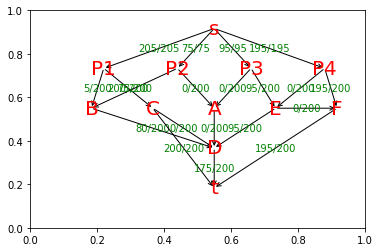

In [0]:
plot()

# Q2

In [0]:
def readDataKiro(fileName):
    file = open(fileName)
    data = [line.strip() for line in file.readlines()]
    file.close()
    Q, nbF, H = np.array(data[0].split()[1::2]).astype(int)
    # Index for deposit
    idxD = int(data[1].split()[1])
    # Index for factory
    idxU = int(data[2].split()[1])
    subcontractCost = []
    stock = []
    costNetwork = np.zeros((nbF+2, nbF+2))
    # Suppose all data is int
    for f in range(nbF):
        line = data[3+f].split()
        subcontractCost.append(int(line[3]))
        stock.append(list(np.array(line[5: 5+H]).astype(int)))
    for line in data[3+nbF:]:
        values = line.split()
        i, j = np.array(values[1:3]).astype(int)
        c = int(values[-1])
        costNetwork[i, j] = c
    return Q, nbF, H, idxD, idxU, subcontractCost, np.array(stock), costNetwork

def getFeasiblePaths(idxD, idxU, costNetwork, group):
    '''
    For each group of providers, we find all feasible
    transport paths
    '''
    paths = []
    num = len(group)
    for i in range(num):
        # Pass only 1 provider
        paths.append([group[i]])
        for j in range(i+1, num):
            # Pass only 2 providers
            paths.append(resortIndex(idxD, idxU, costNetwork, [group[i], group[j]]))
            for m in range(j+1, num):
                # Pass only 3 providers
                paths.append(resortIndex(idxD, idxU, costNetwork, [group[i], group[j], group[m]]))
                for n in range(m+1, num):
                    # Pass only 4 providers
                    paths.append(resortIndex(idxD, idxU, costNetwork, [group[i], group[j], group[m], group[n]]))
    return paths

def resortIndex(idxD, idxU, costNetwork, providers):
    '''
    Resort all providers in one transport with a min cost
    '''
    DfU = []
    for p in providers:
        DfU.append([costNetwork[idxD, p], costNetwork[p, idxU]])
    DfU = np.array(DfU)
    minCostIndex = DfU.argmin(axis=0)
    if minCostIndex[0] != minCostIndex[1]:
        firstProvider = minCostIndex[0]
        lastProvider = minCostIndex[1]
    else:
        minCostIndex = minCostIndex[0]
        DfU[minCostIndex, :] = np.array([np.inf, np.inf])
        scdMinIdx = DfU.argmin(axis=0)
        if DfU[scdMinIdx[0], 0] < DfU[scdMinIdx[1], 1]:
            firstProvider = scdMinIdx[0]
            lastProvider = minCostIndex
        else:
            firstProvider = minCostIndex
            lastProvider = scdMinIdx[1]
    sortedProviders = providers.copy()
    sortedProviders.remove(providers[firstProvider])
    sortedProviders.remove(providers[lastProvider])
    sortedProviders.insert(0, providers[firstProvider])
    sortedProviders.append(providers[lastProvider])
    return sortedProviders

def transportAlongOnePath(Q, idxD, idxU, stock, costNetwork, path, s):
    q = 0
    cost = costNetwork[idxD, path[0]] + costNetwork[path[-1], idxU]
    for i, j in zip(path[:-1], path[1:]):
        cost += costNetwork[i, j]
        q += stock[i, s]
    q += stock[path[-1], s]
    q = min(q, Q)
    return cost, q

def getBestPath(Q, idxD, idxU, stock, costNetwork, group, s):
    paths = getFeasiblePaths(idxD, idxU, costNetwork, group)
    tours = []
    for path in paths:
        tours.append(transportAlongOnePath(Q, idxD, idxU, stock, costNetwork, path, s))
    tours = np.array(tours)
    maxLoadIdx = tours.argmax(axis=0)[1]
    minCostIdx = tours.argmin(axis=0)[0]
    if maxLoadIdx == minCostIdx:
        return paths[maxLoadIdx], tours[maxLoadIdx]
    else:
        return paths[maxLoadIdx], tours[maxLoadIdx]

def updateStock(bestPath, stock, s):
    path = bestPath[0]
    cost, load = bestPath[1]
    loadForEachProvider = []
    for p in path:
        delta = min(stock[p, s], load)
        stock[p, s] = stock[p, s] - delta
        load -= delta
        loadForEachProvider.append(delta)
    return loadForEachProvider

def isStockNull(group, stock, s):
    return stock[group, s].sum() == 0
'''
def getP(Q, idxD, idxU, stock, costNetwork, group, s):
    P = []
    totalCost = 0
    while(not isStockNull(group, stock, s)):
        bestPath = getBestPath(Q, idxD, idxU, stock, costNetwork, group, s)
        path = bestPath[0]
        cost, load = bestPath[1]
        totalCost += cost
        loadForEachProvider = updateStock(bestPath, stock, s)
        P.append([s, path, loadForEachProvider, cost, load])
    return P, totalCost
'''


def isLegalGroup(G):
  '''
  >>> a = np.array([[0, 1, 0], [1, 0, 1], [0, 0, 0]])
  >>> isLegalGroup(a)
  True
  '''
  rows = G.sum(axis=1)
  cols = G.sum(axis=0)
  return np.alltrue(rows<=4) and np.alltrue(cols==1)

def getRandomGroup(notSubcontract):
  nbNotSubcontract = len(notSubcontract)
  G = np.zeros((nbNotSubcontract, nbNotSubcontract))
  for i in range(nbNotSubcontract):
    rand = np.random.randint(0, nbNotSubcontract)
    G[rand, i] = 1
    while not np.alltrue(G.sum(axis=1)<=4):
      G[rand, i] = 0
      rand = np.random.randint(0, nbNotSubcontract)
      G[rand, i] = 1
  return G

def reduceNbGrp(G):
  gCopy = np.array(G).copy()
  return np.delete(gCopy, np.nonzero(gCopy.sum(axis=1) == 0)[0], 0)

def crossoverEA1(G):
  gCopy = G.copy()
  '''idx = np.nonzero(gCopy.sum(axis=1) == 1)[0]'''
  numGrp, numF = gCopy.shape
  i, j = 0, 0
  while i==j and numGrp!=1:
    i = np.random.randint(0, numGrp)
    j = np.random.randint(0, numGrp)
    if gCopy[i, :].sum() == 0 and gCopy[j, :].sum() == 0:
      i = j
      continue
    '''
    i = idx[np.random.randint(0, len(idx))]
    j = idx[np.random.randint(0, len(idx))]
    '''
  # Parents
  pi = gCopy[i, :]
  pj = gCopy[j, :]
  # Sons
  si, sj = np.zeros(numF), np.zeros(numF)
  si[0::2] = pi[0::2]
  si[1::2] = pj[1::2]
  sj[0::2] = pj[0::2]
  sj[1::2] = pi[1::2]
  gCopy[i, :] = si
  gCopy[j, :] = sj
  return gCopy

def mutate(G):
  gCopy = G.copy()
  numGrp, numF = gCopy.shape
  fi = np.random.randint(0, numF)
  pos = np.nonzero(gCopy[:, fi] == 1)[0][0]
  gi = np.random.randint(0, numGrp)
  gCopy[pos, fi] = 0
  gCopy[gi, fi] = 1
  return gCopy

def getFitness(notSubcontract, G, Q, nbF, idxD, idxU, stock, costNetwork, H):
  cost = 0
  reducedG = reduceNbGrp(G)
  P = []
  numP = 0
  for nbG in range(reducedG.shape[0]):
    group = notSubcontract[np.nonzero(reducedG[nbG, :]==1)[0]]
    token = "_".join(group.astype(str))
    path = "./C/{}.pkl".format(token)
    if os.path.exists(path):
      with open(path, "rb") as f:
        subP, subNumP, subCost = pickle.load(f)
      numP += subNumP
      cost += subCost
      P += subP
      continue
    subP = []
    subNumP = 0
    subCost = 0
    for s in range(H):
      p, eachCost = getP(Q, idxD, idxU, stock.copy(), costNetwork, group, s)
      if len(p) == 0:
        continue
      subNumP += len(p)
      subCost += eachCost
      subP.append(p)
      with open(path, "wb") as f:
        pickle.dump([subP, subNumP, subCost], f)
    numP += subNumP
    cost += subCost
    P += subP
  return cost, P, numP

def EA1(sol, notSubcontract, Q, nbF, idxD, idxU, stock, costNetwork, H, generations=100):
  nbNotSubcontract = len(notSubcontract)
  # Initial solution
  token = "".join(sol.astype(int).astype(str))
  G = np.loadtxt("./G/0.txt")
  '''
  if token in sol2G.keys():
    G = sol2G[token]
  else:
    G = getRandomGroup(notSubcontract)
  '''
  fitness, P, numP = getFitness(notSubcontract, G, Q, nbF, idxD, idxU, stock, costNetwork, H)
  for i in range(generations):
    newG = mutate(crossoverEA1(G))
    while not isLegalGroup(newG):
      newG = mutate(crossoverEA1(G))
    newFitness, newP, newNumP = getFitness(notSubcontract, newG, Q, nbF, idxD, idxU, stock, costNetwork, H)
    if newFitness < fitness:
      G = newG.copy()
      fitness = newFitness
      P = newP
      numP = newNumP
      '''
      sol2G[token] = G
      '''
      np.savetxt("./G/0.txt", G)
  return G, fitness, P, numP


def subcontract(nbF):
    sol = np.random.randint(2, size=nbF)
    notSubcontract = np.nonzero(sol==0)[0]
    isSubcontract = np.nonzero(sol==1)[0]
    return sol, isSubcontract, notSubcontract

def calculateFitness(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, sol, threshold):
    costSubcontract = np.matmul(sol, subcontractCost)

    notSubcontract = np.nonzero(sol==0)[0]
    if  costSubcontract < threshold and len(notSubcontract):
        grp, costNotSubcontract, P, numP = EA1(sol, notSubcontract, Q, nbF, idxD, idxU, stock, costNetwork, H)
    else:
        grp = getRandomGroup(notSubcontract)
        costNotSubcontract, P, numP = getFitness(notSubcontract, grp, Q, nbF, idxD, idxU, stock, costNetwork, H)
    return costSubcontract+costNotSubcontract, grp, P, numP

def getOffsprings(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, sols, threshold):
  numSols = len(sols)
  newSols = []
  newFits = []
  newGrps = []
  newP = []
  newN = []
  for i in range(numSols):
    for j in range(i+1, numSols):
      soli = sols[i]
      solj = sols[j]
      newSoli, newSolj = np.zeros(nbF), np.zeros(nbF)
      newSoli[0::2] = soli[0::2]
      newSoli[1::2] = solj[1::2]
      newSolj[0::2] = solj[0::2]
      newSolj[1::2] = soli[1::2]
      randi = np.random.randint(0, nbF)
      randj = np.random.randint(0, nbF)
      newSoli[randi] = 1-newSoli[randi]
      newSolj[randj] = 1-newSolj[randj]
      newSols.append(newSoli)
      newSols.append(newSolj)
      fiti, grpi, pi, ni = calculateFitness(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, newSoli, threshold)
      fitj, grpj, pj, nj = calculateFitness(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, newSolj, threshold)
      newFits.append(fiti)
      newFits.append(fitj)
      newGrps.append(grpi)
      newGrps.append(grpj)
      newP.append(pi)
      newP.append(pj)
      newN.append(ni)
      newN.append(nj)
  nSols, nFits, nGrps, nP, nN = getInitRandSols(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, numSols, threshold)
  newSols += nSols
  newFits += nFits
  newGrps += nGrps
  newP += nP
  newN += nN
  return newSols, newFits, newGrps, newP, newN

def select(sols, fits, grps, P, N, nbWinners=5):
  solsCopy = np.array(sols.copy())
  fitsCopy = np.array(fits.copy())
  grpsCopy = np.array(grps.copy())
  pCopy = np.array(P.copy())
  nCopy = np.array(N.copy())
  w = np.argsort(fitsCopy)[:nbWinners]
  return solsCopy[w], fitsCopy[w].tolist(), grpsCopy[w].tolist(), pCopy[w].tolist(), nCopy[w].tolist()

def getInitRandSols(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, numSols, threshold):
  sols = []
  fits = []
  grps = []
  P = []
  N = []
  for num in range(numSols):
    sol = np.random.randint(2, size=nbF)
    # Get a random solution for subcontract or non-subcontract
    rand = np.random.randint(nbF)
    idx = np.argsort(subcontractCost)[:rand]*np.random.randint(2, size=rand)
    sol[idx[np.nonzero(idx>0)]] = 1
    isSubcontract = np.nonzero(sol==1)[0]
    notSubcontract = np.nonzero(sol==0)[0]
    # If subcontract cost is big enough, ignore it
    if np.matmul(sol, subcontractCost) >= threshold:
        continue
    sols.append(sol)
    fit, grp, p, num = calculateFitness(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, sol, threshold)
    fits.append(fit)
    grps.append(grp)
    P.append(p)
    N.append(num)
  return sols, fits, grps, P, N

def EA(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H):
  numSols = 10
  try:
    threshold = float(os.listdir("usine/")[0].split(".")[0])
    threshold = 1e11
  except:
    threshold = 1e11
  sols, fits, grps, P, N = getInitRandSols(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, numSols, threshold)
  # Generation number
  for g in range(1000):
    sols, fits, grps, P, N = select(sols, fits, grps, P, N)
    if g%10 == 0:
      print("Generation:{} cost:{}".format(g, fits[0]))
      output(nbF, sols[0], fits[0], reduceNbGrp(grps[0]), P[0], N[0])
      threshold = fits[0]

    newSols, newFits, newGrps, newP, newN = getOffsprings(Q, nbF, idxD, idxU, subcontractCost, stock, costNetwork, H, sols, threshold)
    sols = sols.tolist() + newSols
    fits = fits + newFits
    grps = grps + newGrps
    P = P + newP
    N = N + newN

    with open("sol2G.pkl", "wb") as f:
      pickle.dump(sol2G, f)
  sols, fits, grps, P, N = select(sols, fits, grps, P, N)
  return sols[0], fits[0], reduceNbGrp(grps[0]), P[0], N[0]


def output(nbF, sol, fit, grp, P, num):
  sol = np.array(sol)
  notSubcontract = np.nonzero(sol==0)[0].tolist()
  file = open("usine/{}.txt".format(fit), "w+")
  file.write("x {} f {}\n".format(int(sol.sum()), " ".join(np.nonzero(sol==1)[0].astype(str))))
  file.write("y {}\n".format(num))
  file.write("z {}\n".format(grp.shape[0]))
  for c in range(grp.shape[0]):
    f = np.array(notSubcontract)[np.nonzero(grp[c, :]==1)[0]].astype(str)
    file.write("C {} n {} f {}\n".format(c, int(grp[c, :].sum()), " ".join(f)))
  count = 0
  for p in P:
    for ep in p:
      idx = []
      for f in ep[1]:
        idx.append(notSubcontract.index(f))
      g = np.nonzero(grp[:, idx]==1)[0].tolist()
      assert g.count(g[0])==len(g), "check matrix G"
      s = ep[0]
      n = len(ep[1])
      line = "P {} g {} s {} n {}".format(count, g[0], s, n)
      for f, load in zip(ep[1], ep[2]):
        suf = " f {} {}".format(f, int(load))
        line = line + suf
      file.write(line)
      file.write("\n")
      count += 1
  file.close()

def keepBestFile():
  values = []
  for file in os.listdir("usine/"):
    values.append(float(file.split(".")[0]))
  for file in os.listdir("usine/"):
    if str(min(values)) not in file:
      os.remove("usine/{}".format(file))

def readSolution(solName):
  file = open(solName)
  data = [line.strip() for line in file.readlines()]
  file.close()
  line = data[0].split()
  nX = int(line[1])
  X = np.array(line[3:]).astype(int).tolist()
  nY = int(data[1].split()[1])
  nZ = int(data[2].split()[1])
  C = []
  for d in data[3:3+nZ]:
    line = d.split()
    nb = int(line[1])
    f = np.array(line[5:]).astype(int).tolist()
    C.append(f)
  P = []
  for d in data[3+nZ:]:
    line = d.split()
    nbG = int(line[3])
    s = int(line[5])
    f = [nbG, s]
    nbF = int(line[7])
    for n in range(8, 8+3*nbF):
      if (n-8)%3:
        f.append(int(line[n]))
    P.append(f)
  return nX, X, nY, nZ, C, P

def checkSolution(solName):
  Q, nbF, H, idxD, idxU, subcontractCost, stock, costNetwork = readDataKiro("usine.csv")
  nX, X, nY, nZ, C, P = readSolution(solName)
  # Check group
  grp = X
  for c in C:
    assert len(c) <= 4, "|C| > 4"
    grp = grp + c
  assert len(grp) == nbF, "Fournisseur number incorrect"
  assert np.alltrue(np.sort(grp)==np.array(range(nbF))), "Fournisseur absent or double-written"

  # Check load
  cost = np.array(subcontractCost)[X].sum()
  stock = np.array(stock)
  for p in P:
    s = p[1]
    F = p[2:][0::2]
    LOAD = p[2:][1::2]
    cost += costNetwork[idxD, F[0]] + costNetwork[F[-1], idxU]
    for f1, f2 in zip(F[:-1], F[1:]):
      cost += costNetwork[f1, f2]
    for f, load in zip(F, LOAD):
      stock[f, s] = stock[f, s] - load
  stock = np.delete(stock, X, axis=0)
  assert np.alltrue(stock == 0), "Load remained"
  print(cost)
  print("Solution is ok")


def combinations(n, i):
  return factorial(n)/(factorial(n-i)*factorial(i))

def sol2num(sol):
  length = sol.shape[0]
  pos = np.nonzero(sol==1)[0]
  if len(pos) == 0:
    return 0
  nb1 = pos.shape[0]
  value = 0
  for i in range(pos.shape[0]):
    value += combinations(length, i)
  if len(pos) == 1:
    return value + pos[0]
  for j in range(pos[0]):
    value += combinations(length-1-j, nb1-1)
  for i in range(1, nb1):
    for j in range(pos[i]-pos[i-1]-1):
      value += combinations(length-pos[i-1]-1-j, nb1-1-i)
  return value

In [0]:
def allPaths(group):
  paths = []
  for i in range(len(group)):
    paths += permutations(group, r=i+1)
  return paths

def getCostLoad(path, costNetwork, idxD, idxU, Q, stock, s):
  cost = costNetwork[idxD, path[0]] + costNetwork[path[-1], idxU]
  load = 0
  for f1, f2 in zip(path[:-1], path[1:]):
    load += min(Q, stock[f1, s])
    cost += costNetwork[f1, f2]
  load += min(Q, stock[path[-1], s])
  return cost, min(Q, load)

def pickBestPath(group, costNetwork, idxD, idxU, Q, stock, s):
  values = []
  paths = allPaths(group)
  for path in paths:
    values.append(getCostLoad(path, costNetwork, idxD, idxU, Q, stock, s))
  values = np.array(values)
  #value[np.nonzero(value[:, 1]==0), 0] = np.inf
  maxLoad = values[:, 1].max()
  argMaxLoad = np.nonzero(values[:, 1] == maxLoad)[0]
  argMinCost = values[argMaxLoad].argmin(axis=0)[0]
  return np.array(paths)[argMaxLoad][argMinCost], values[argMaxLoad, :][argMinCost, :].tolist()

def getP(Q, idxD, idxU, stock, costNetwork, group, s):
  totalCost = 0
  P = []
  while not isStockNull(group, stock, s):
    path, value = pickBestPath(group, costNetwork, idxD, idxU, Q, stock, s)
    cost, load = value
    totalCost += cost
    loadForEachProvider = updateStock([path, value], stock, s)
    P.append([s, path, loadForEachProvider, cost, load])
  return P, totalCost

def checkSequence(group, sequence, stock, s):
  allCost = 0
  for path, cost, load in sequence:
    updateStock([path, [cost, load]], stock, s)
    allCost += cost
  return isStockNull(group, stock, s), allCost

In [0]:
def G0():
  t0 = time()
  Q, nbF, H, idxD, idxU, subcontractCost, stock, costNetwork = readDataKiro("usine.csv")
  for i in range(10):
    sol = np.zeros(nbF)
    notSubcontract = np.nonzero(sol==0)[0]
    G, fit, P, numP = EA1(sol, notSubcontract, Q, nbF, idxD, idxU, stock, costNetwork, H, generations=10000)
    print(i, fit)
    output(nbF, sol, fit, reduceNbGrp(G), P, numP)
  keepBestFile()
  print("finished with {} minutes".format(round((time()-t0)/60, 2)))

G0()

0 3414793845.0
1 3414678134.0
2 3414678134.0


In [13]:
def pickFL(F, LOAD):
  nF = []
  nLOAD = []
  for f, load in zip(F, LOAD):
    if load:
      nF.append(f)
      nLOAD.append(load)
  return nF, nLOAD

def optimizeSolition():
    Q, nbF, H, idxD, idxU, subcontractCost, stock, costNetwork = readDataKiro("usine.csv")
    solName = "usine/{}".format(os.listdir("usine/")[0])
    solName = "usine/temp.txt"
    nX, X, nY, nZ, C, P = readSolution(solName)

    G = np.zeros((len(C), nbF-len(X)))
    sol = np.zeros(nbF)
    sol[X] = 1
    nonSubcontract = np.nonzero(sol==0)[0].tolist()
    for i in range(len(C)):
      for f in C[i]:
        G[i, nonSubcontract.index(f)] = 1

    # Check load
    totalCost = np.array(subcontractCost)[X].sum()
    stock = np.array(stock)
    nP = []

    for p in P:
        s = p[1]
        F = p[2:][0::2]
        LOAD = p[2:][1::2]

        nF, nLOAD = pickFL(F, LOAD)

        cost1 = costNetwork[idxD, nF[0]] + costNetwork[nF[-1], idxU]
        for f1, f2 in zip(nF[:-1], nF[1:]):
          cost1 += costNetwork[f1, f2]

        cost2 = costNetwork[idxD, F[0]] + costNetwork[F[-1], idxU]
        for f1, f2 in zip(F[:-1], F[1:]):
            cost2 += costNetwork[f1, f2]

        if cost1 < cost2:
          nP.append([[s, nF, nLOAD, np.inf, np.inf]])
        else:
          nP.append([[s, F, LOAD, np.inf, np.inf]])
        totalCost += min(cost1, cost2)
    output(nbF, sol, totalCost, reduceNbGrp(G), nP, len(P))

def regroup():
  fileName = "usine.csv"
  t0 = time()
  Q, nbF, H, idxD, idxU, subcontractCost, stock, costNetwork = readDataKiro(fileName)
  curCost = float(os.listdir("usine/")[0].split(".")[0])

  for i in range(1000):
    sol = np.zeros(nbF)
    G = np.loadtxt("G/{}.txt".format(sol2num(sol)))
    rand = np.random.randint(nbF)
    idx = np.argsort(subcontractCost)[:rand]*np.random.randint(2, size=rand)
    sol[idx[np.nonzero(idx>0)]] = 1
    isSubcontract = np.nonzero(sol==1)[0]
    notSubcontract = np.nonzero(sol==0)[0]
    cost1 = np.matmul(sol, subcontractCost)
    assert cost1 == np.array(subcontractCost)[isSubcontract].sum()
    if cost1 >= curCost:
      continue
    nG = np.delete(G, isSubcontract, axis=1)
    cost2, P, numP = getFitness(notSubcontract, nG, Q, nbF, idxD, idxU, stock, costNetwork, H)
    if cost1+cost2 < curCost:
      #np.savetxt("G/{}.txt".format(sol2num(sol)), nG)
      output(nbF, sol, "temp", reduceNbGrp(nG), P, numP)
      optimizeSolition()
  os.remove("usine/temp.txt")
  keepBestFile()
  print("finished with {} minutes".format(round((time()-t0)/60, 2)))

regroup()

finished with 13.26 minutes


In [0]:
checkSolution("usine/3426289791.0.txt")

3426289791.0
Solution is ok


In [0]:
checkSolution("usine/{}".format(os.listdir("usine/")[0]))

3426654915.0
Solution is ok


In [0]:
def crossoverEA2(sols):
    numGrp, numF = np.array(sols[0]).shape
    numSols = len(sols)
    newSols = []
    for i in range(numSols):
        for j in range(i+1, numSols):
            soli = np.array(sols[i])
            solj = np.array(sols[j])
            newSoli, newSolj = np.zeros((numGrp, numF)), np.zeros((numGrp, numF))
            newSoli[:, 0::2] = soli[:, 0::2]
            newSoli[:, 1::2] = solj[:, 1::2]
            newSolj[:, 0::2] = solj[:, 0::2]
            newSolj[:, 1::2] = soli[:, 1::2]
            newSoli = mutate(newSoli)
            newSolj = mutate(newSolj)
            if isLegalGroup(newSoli):
                newSols.append(newSoli)
            if isLegalGroup(newSolj):
                newSols.append(newSolj)
    return newSols

def getRandGrps(notSubcontract, Q, nbF, idxD, idxU, stock, costNetwork, H, num=5):
    nbNotSubcontract = len(notSubcontract)
    grps = []
    fits = []
    Ps = []
    numPs = []
    for i in range(num):
        G = getRandomGroup(notSubcontract)
        grps.append(G)
        fitness, P, numP = getFitness(notSubcontract, G, Q, nbF, idxD, idxU, stock, costNetwork, H)
        fits.append(fitness)
        Ps.append(P)
        numPs.append(numP)
    return grps, fits, Ps, numPs


def EA2(notSubcontract, Q, nbF, idxD, idxU, stock, costNetwork, H):
    generation = 1
    grps, fits, Ps, numPs = getRandGrps(notSubcontract, Q, nbF, idxD, idxU, stock, costNetwork, H)
    for g in range(generation):
        _, fits, grps, Ps, numPs = select(grps, fits, grps, Ps, numPs)
        for grp in crossoverEA2(grps):
            grps.append(grps)
            fitness, P, numP = getFitness(notSubcontract, grp, Q, nbF, idxD, idxU, stock, costNetwork, H)
            fits.append(fitness)
            Ps.append(P)
            numPs.append(numP)
        newGrps, newFits, newPs, newNumPs = getRandGrps(notSubcontract, Q, nbF, idxD, idxU, stock, costNetwork, H)
        grps= grps + newGrps
        fits = fits + newFits
        Ps = Ps + newPs
        numPs = numPs + newNumPs
    _, fits, grps, Ps, numPs = select(grps, fits, grps, Ps, numPs)
    return reduceNbGrp(grps[0]), fits[0], Ps[0], numPs[0]